In [1]:
import os
# import pkg_resources
# pkg_resources.require('Torch==2.0.1')
!pip install torch==2.0.1
import torch
print('Using torch', torch.__version__)
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install ogb
!pip install rdkit-pypi

Using torch 2.0.1+cu117
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html


In [46]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import MessagePassing
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.utils import degree
from torch_geometric.utils import to_dense_batch

from ogb.graphproppred.mol_encoder import BondEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp, global_add_pool as gsp

from torch_geometric.utils import to_dense_batch

# from models.layers import SAB, ISAB, PMA
# from models.layers import GCNConv_for_OGB, GINConv_for_OGB

from ogb.graphproppred.mol_encoder import AtomEncoder

from math import ceil

# set seed
seed_value = 37
torch.manual_seed(seed_value)

class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False, cluster=False, conv=None):
        super(MAB, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)

        self.fc_k, self.fc_v = self.get_fc_kv(dim_K, dim_V, conv)

        if ln:
            self.ln0 = nn.LayerNorm(dim_V)
            self.ln1 = nn.LayerNorm(dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V)

        self.softmax_dim = 2
        if cluster == True:
            self.softmax_dim = 1

    def forward(self, Q, K, attention_mask=None, graph=None, return_attn=False):
        Q = self.fc_q(Q)

        # Adj: Exist (graph is not None), or Identity (else)
        if graph is not None:

            (x, edge_index, batch) = graph

            K, V = self.fc_k(x, edge_index), self.fc_v(x, edge_index)

            K, _ = to_dense_batch(K, batch)
            V, _ = to_dense_batch(V, batch)

        else:

            K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)

        if attention_mask is not None:
            attention_mask = torch.cat([attention_mask for _ in range(self.num_heads)], 0)
            attention_score = Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V)
            A = torch.softmax(attention_mask + attention_score, self.softmax_dim)
        else:
            A = torch.softmax(Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V), self.softmax_dim)

        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        if return_attn:
            return O, A
        else:
            return O

    def get_fc_kv(self, dim_K, dim_V, conv):

        if conv == 'GCN':

            fc_k = GCNConv(dim_K, dim_V)
            fc_v = GCNConv(dim_K, dim_V)

        elif conv == 'GIN':

            fc_k = GINConv(
                nn.Sequential(
                    nn.Linear(dim_K, dim_K),
                    nn.ReLU(),
                    nn.Linear(dim_K, dim_V),
                    nn.ReLU(),
                    nn.BatchNorm1d(dim_V),
            ), train_eps=False)

            fc_v = GINConv(
                nn.Sequential(
                    nn.Linear(dim_K, dim_K),
                    nn.ReLU(),
                    nn.Linear(dim_K, dim_V),
                    nn.ReLU(),
                    nn.BatchNorm1d(dim_V),
            ), train_eps=False)

        else:

            fc_k = nn.Linear(dim_K, dim_V)
            fc_v = nn.Linear(dim_K, dim_V)

        return fc_k, fc_v

class SAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, ln=False, cluster=False, mab_conv=None):
        super(SAB, self).__init__()

        self.mab = MAB(dim_in, dim_in, dim_out, num_heads, ln=ln, cluster=cluster, conv=mab_conv)

    def forward(self, X, attention_mask=None, graph=None):
        return self.mab(X, X, attention_mask, graph)

class ISAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, num_inds, ln=False, cluster=False, mab_conv=None):
        super(ISAB, self).__init__()
        self.I = nn.Parameter(torch.Tensor(1, num_inds, dim_out))
        nn.init.xavier_uniform_(self.I)

        self.mab0 = MAB(dim_out, dim_in, dim_out, num_heads, ln=ln, cluster=cluster, conv=mab_conv)
        self.mab1 = MAB(dim_in, dim_out, dim_out, num_heads, ln=ln, cluster=cluster, conv=mab_conv)

    def forward(self, X, attention_mask=None, graph=None):
        H = self.mab0(self.I.repeat(X.size(0), 1, 1), X, attention_mask, graph)
        return self.mab1(X, H)

class PMA(nn.Module):
    def __init__(self, dim, num_heads, num_seeds, ln=False, cluster=False, mab_conv=None):
        super(PMA, self).__init__()
        self.S = nn.Parameter(torch.Tensor(1, num_seeds, dim))
        nn.init.xavier_uniform_(self.S)

        self.mab = MAB(dim, dim, dim, num_heads, ln=ln, cluster=cluster, conv=mab_conv)

    def forward(self, X, attention_mask=None, graph=None, return_attn=False):
        return self.mab(self.S.repeat(X.size(0), 1, 1), X, attention_mask, graph, return_attn)

### GCN convolution along the graph structure
class GCNConv_for_OGB(MessagePassing):
    def __init__(self, emb_dim):
        super(GCNConv_for_OGB, self).__init__(aggr='add')

        self.linear = torch.nn.Linear(emb_dim, emb_dim)
        self.root_emb = torch.nn.Embedding(1, emb_dim)
        self.bond_encoder = BondEncoder(emb_dim = emb_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.linear(x)
        edge_embedding = self.bond_encoder(edge_attr)

        row, col = edge_index

        deg = degree(row, x.size(0), dtype = x.dtype) + 1
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return self.propagate(edge_index, x=x, edge_attr=edge_embedding, norm=norm) + F.relu(x + self.root_emb.weight) * 1./deg.view(-1,1)

    def message(self, x_j, edge_attr, norm):
        return norm.view(-1, 1) * F.relu(x_j + edge_attr)

    def update(self, aggr_out):
        return aggr_out

### GIN convolution along the graph structure
class GINConv_for_OGB(MessagePassing):
    def __init__(self, emb_dim):
        super(GINConv_for_OGB, self).__init__(aggr = "add")

        self.mlp = torch.nn.Sequential(torch.nn.Linear(emb_dim, 2*emb_dim), torch.nn.BatchNorm1d(2*emb_dim), torch.nn.ReLU(), torch.nn.Linear(2*emb_dim, emb_dim))
        self.eps = torch.nn.Parameter(torch.Tensor([0]))

        self.bond_encoder = BondEncoder(emb_dim = emb_dim)

    def forward(self, x, edge_index, edge_attr):
        edge_embedding = self.bond_encoder(edge_attr)
        out = self.mlp((1 + self.eps) * x + self.propagate(edge_index, x=x, edge_attr=edge_embedding))

        return out

    def message(self, x_j, edge_attr):
        return F.relu(x_j + edge_attr)

    def update(self, aggr_out):
        return aggr_out

In [3]:
class GraphRepresentation(torch.nn.Module):

    def __init__(self, args):

        super(GraphRepresentation, self).__init__()

        self.args = args
        self.num_features = args.num_features
        self.nhid = args.num_hidden
        self.num_classes = args.num_classes
        self.pooling_ratio = args.pooling_ratio
        self.dropout_ratio = args.dropout

    def get_convs(self):

        convs = nn.ModuleList()

        _input_dim = self.num_features
        _output_dim = self.nhid

        for _ in range(self.args.num_convs):

            if self.args.conv == 'GCN':

                conv = GCNConv(_input_dim, _output_dim)

            elif self.args.conv == 'GIN':

                conv = GINConv(
                    nn.Sequential(
                        nn.Linear(_input_dim, _output_dim),
                        nn.ReLU(),
                        nn.Linear(_output_dim, _output_dim),
                        nn.ReLU(),
                        nn.BatchNorm1d(_output_dim),
                ), train_eps=False)

            convs.append(conv)

            _input_dim = _output_dim
            _output_dim = _output_dim

        return convs

    def get_pools(self):

        pools = nn.ModuleList([gap])

        return pools

    def get_classifier(self):

        return nn.Sequential(
            nn.Linear(self.nhid, self.nhid),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_ratio),
            nn.Linear(self.nhid, self.nhid//2),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_ratio),
            nn.Linear(self.nhid//2, self.num_classes)
        )

class GraphMultisetTransformer(GraphRepresentation):

    def __init__(self, args):

        super(GraphMultisetTransformer, self).__init__(args)

        self.ln = args.ln
        self.num_heads = args.num_heads
        self.cluster = args.cluster

        self.model_sequence = args.model_string.split('-')

        self.convs = self.get_convs()
        self.pools = self.get_pools()
        self.classifier = self.get_classifier()

    def forward(self, data):

        x, edge_index, batch = data.x, data.edge_index, data.batch

        # For Graph Convolution Network
        xs = []

        for _ in range(self.args.num_convs):

            x = F.relu(self.convs[_](x, edge_index))
            xs.append(x)

        # For jumping knowledge scheme
        x = torch.cat(xs, dim=1)

        # For Graph Multiset Transformer
        for _index, _model_str in enumerate(self.model_sequence):

            if _index == 0:

                batch_x, mask = to_dense_batch(x, batch)

                extended_attention_mask = mask.unsqueeze(1)
                extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
                extended_attention_mask = (1.0 - extended_attention_mask) * -1e9

            if _model_str == 'GMPool_G':

                batch_x = self.pools[_index](batch_x, attention_mask=extended_attention_mask, graph=(x, edge_index, batch))

            else:

                batch_x = self.pools[_index](batch_x, attention_mask=extended_attention_mask)

            extended_attention_mask = None

        batch_x = self.pools[len(self.model_sequence)](batch_x)
        x = batch_x.squeeze(1)

        # For Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=-1)

    def get_pools(self, _input_dim=None, reconstruction=False):

        pools = nn.ModuleList()

        _input_dim = self.nhid * self.args.num_convs if _input_dim is None else _input_dim
        _output_dim = self.nhid
        _num_nodes = ceil(self.pooling_ratio * self.args.avg_num_nodes)

        for _index, _model_str in enumerate(self.model_sequence):

            if (_index == len(self.model_sequence) - 1) and (reconstruction == False):

                _num_nodes = 1

            if _model_str == 'GMPool_G':

                pools.append(
                    PMA(_input_dim, self.num_heads, _num_nodes, ln=self.ln, cluster=self.cluster, mab_conv=self.args.mab_conv)
                )

                _num_nodes = ceil(self.pooling_ratio * _num_nodes)

            elif _model_str == 'GMPool_I':

                pools.append(
                    PMA(_input_dim, self.num_heads, _num_nodes, ln=self.ln, cluster=self.cluster, mab_conv=None)
                )

                _num_nodes = ceil(self.pooling_ratio * _num_nodes)

            elif _model_str == 'SelfAtt':

                pools.append(
                    SAB(_input_dim, _output_dim, self.num_heads, ln=self.ln, cluster=self.cluster)
                )

                _input_dim = _output_dim
                _output_dim = _output_dim

            else:

                raise ValueError("Model Name in Model String <{}> is Unknown".format(_model_str))

        pools.append(nn.Linear(_input_dim, self.nhid))

        return pools

class GraphMultisetTransformer_for_OGB(GraphMultisetTransformer):

    def __init__(self, args):

        super(GraphMultisetTransformer_for_OGB, self).__init__(args)

        self.atom_encoder = AtomEncoder(self.nhid)
        self.convs = self.get_convs()

    def forward(self, data):

        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.atom_encoder(x)

        # For Graph Convolution Network
        xs = []

        for _ in range(self.args.num_convs):

            x = F.relu(self.convs[_](x, edge_index, edge_attr))
            xs.append(x)

        # For jumping knowledge scheme
        x = torch.cat(xs, dim=1)

        # For Graph Multiset Transformer
        for _index, _model_str in enumerate(self.model_sequence):

            if _index == 0:

                batch_x, mask = to_dense_batch(x, batch)

                extended_attention_mask = mask.unsqueeze(1)
                extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
                extended_attention_mask = (1.0 - extended_attention_mask) * -1e9

            if _model_str == 'GMPool_G':

                batch_x = self.pools[_index](batch_x, attention_mask=extended_attention_mask, graph=(x, edge_index, batch))

            else:

                batch_x = self.pools[_index](batch_x, attention_mask=extended_attention_mask)

            extended_attention_mask = None

        batch_x = self.pools[len(self.model_sequence)](batch_x)
        x = batch_x.squeeze(1)

        # For Classification
        x = self.classifier(x)

        return x

    def get_convs(self):

        convs = nn.ModuleList()

        for _ in range(self.args.num_convs):

            if self.args.conv == 'GCN':

                conv = GCNConv_for_OGB(self.nhid)

            elif self.args.conv == 'GIN':

                conv = GINConv_for_OGB(self.nhid)

            convs.append(conv)

        return convs

In [47]:
import matplotlib.pyplot as plt

def plot_training_metrics(losses, val_metrics, test_metrics, epoch_times):
    """
    Plot training loss, validation metric, and test metric over epochs.

    Parameters:
    - losses: List of training losses for each epoch.
    - val_metrics: List of validation metrics for each epoch.
    - test_metrics: List of test metrics for each epoch.
    """
    epochs = range(1, len(losses) + 1)

    # Plotting training loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, losses, label='Training Loss', marker='o')
    plt.title('Training Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting validation and test metrics
    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_metrics, label='Validation Metric', marker='o')
    plt.plot(epochs, test_metrics, label='Test Metric', marker='o')
    plt.title('Validation and Test Metrics vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()

    # Plotting time vs. epoch
    plt.subplot(1, 3, 3)
    plt.plot(epochs, epoch_times, label='Time per Epoch', marker='o', color='orange')
    plt.title('Time vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Time (seconds)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_training_metrics(training_losses, validation_metrics, test_metrics)

Epoch: 001, Loss: 0.6727, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 002, Loss: 0.6760, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 003, Loss: 0.6774, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 004, Loss: 0.6763, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 005, Loss: 0.6745, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 006, Loss: 0.6757, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 007, Loss: 0.6725, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 008, Loss: 0.6741, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 009, Loss: 0.6724, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 010, Loss: 0.6730, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 011, Loss: 0.6717, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 012, Loss: 0.6732, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 013, Loss: 0.6723, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 014, Loss: 0.6729, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 015, Loss: 0.6707, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 016, Loss: 0.6709, Val Acc: 0.5714, Test Acc: 0.5982
Epoch: 017, Loss: 0.6672, Val Acc: 0.571

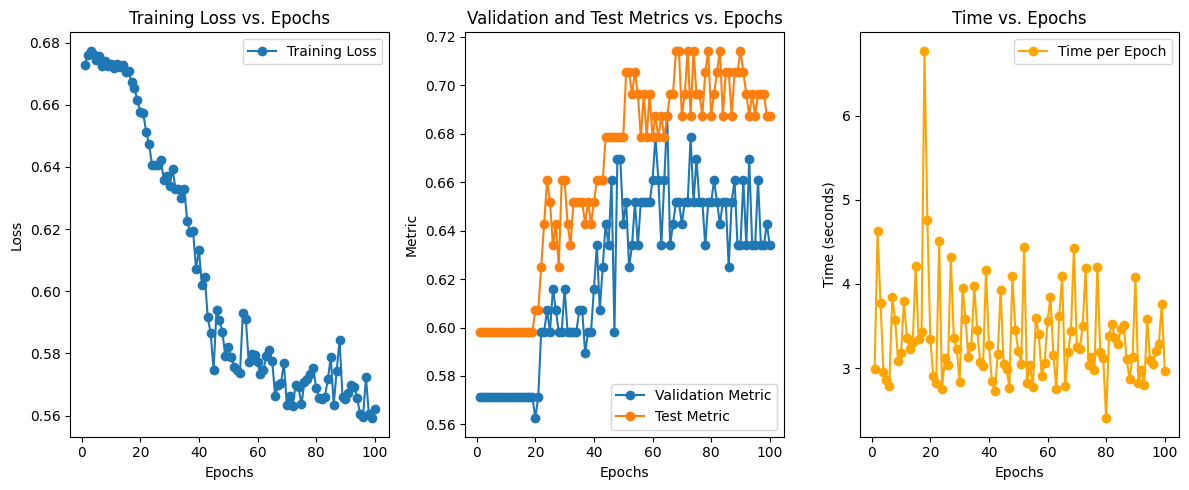

Best Validation Metric: 0.6875
Test Metric: 0.6875
Epoch: 001, Loss: 0.6821, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 002, Loss: 0.6815, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 003, Loss: 0.6813, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 004, Loss: 0.6813, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 005, Loss: 0.6804, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 006, Loss: 0.6808, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 007, Loss: 0.6812, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 008, Loss: 0.6803, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 009, Loss: 0.6805, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 010, Loss: 0.6800, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 011, Loss: 0.6811, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 012, Loss: 0.6810, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 013, Loss: 0.6802, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 014, Loss: 0.6796, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 015, Loss: 0.6814, Val Acc: 0.5932, Test Acc: 0.6356
Epoch: 016, Loss: 0.6798, Val Acc: 0.5932, Test A

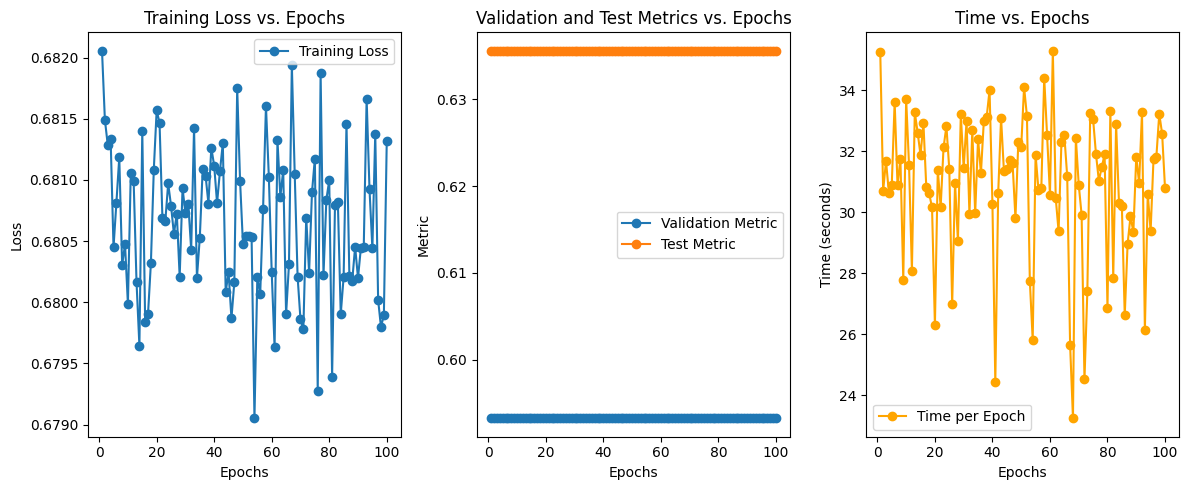

Best Validation Metric: 0.5932203389830508
Test Metric: 0.635593220338983


In [48]:
import os.path as osp
import time
import numpy as np

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GraphMultisetTransformer

def tud_trans(dataset_name, k, h):
  path = 'tmp\tud'
  dataset = TUDataset(path, name=dataset_name).shuffle()

  n = (len(dataset) + 9) // 10
  train_dataset = dataset[2 * n:]
  val_dataset = dataset[n:2 * n]
  test_dataset = dataset[:n]

  train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=128)
  test_loader = DataLoader(test_dataset, batch_size=128)


  class Net(torch.nn.Module):
      def __init__(self):
          super().__init__()

          self.conv1 = GCNConv(dataset.num_features, 32)
          self.conv2 = GCNConv(32, 32)
          self.conv3 = GCNConv(32, 32)

          self.pool = GraphMultisetTransformer(96, k=k, heads=h)

          self.lin1 = Linear(96, 16)
          self.lin2 = Linear(16, dataset.num_classes)

      def forward(self, x0, edge_index, batch):
          x1 = self.conv1(x0, edge_index).relu()
          x2 = self.conv2(x1, edge_index).relu()
          x3 = self.conv3(x2, edge_index).relu()
          x = torch.cat([x1, x2, x3], dim=-1)

          x = self.pool(x, batch)

          x = self.lin1(x).relu()
          x = F.dropout(x, p=0.5, training=self.training)
          x = self.lin2(x)

          return x


  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Net().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)


  def train():
      model.train()

      total_loss = 0
      for data in train_loader:
          data = data.to(device)
          optimizer.zero_grad()
          out = model(data.x, data.edge_index, data.batch)
          loss = F.cross_entropy(out, data.y)
          loss.backward()
          total_loss += data.num_graphs * float(loss)
          optimizer.step()
      return total_loss / len(train_dataset)


  @torch.no_grad()
  def test(loader):
      model.eval()

      total_correct = 0
      for data in loader:
          data = data.to(device)
          out = model(data.x, data.edge_index, data.batch)
          total_correct += int((out.argmax(dim=-1) == data.y).sum())
      return total_correct / len(loader.dataset)


  times = []
  training_losses = []
  validation_metrics = []
  test_metrics = []
  for epoch in range(1, 101):
      start = time.time()
      train_loss = train()
      val_acc = test(val_loader)
      test_acc = test(test_loader)
      training_losses.append(train_loss)
      validation_metrics.append(val_acc)
      test_metrics.append(test_acc)
      print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, '
            f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
      times.append(time.time() - start)
  print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

  plot_training_metrics(training_losses, validation_metrics, test_metrics, times)
  print(f'Best Validation Metric: {max(validation_metrics)}')
  print(f'Test Metric: {test_metrics[np.argmax(validation_metrics)]}')

tud_trans('PROTEINS', k=10, h=4)
tud_trans('DD', k=8, h=2)

# New Section